In [1]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *


In [2]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)

# Actually import
import_opt = {'num_slices':33, 'alpha':0.15}

In [40]:
ref_frames, all_matches, pairwise_matches, pairwise_conf, feature_matches = track_via_reference_frames(btf_fname_red, num_reference_frames=6, verbose=1)

  0%|                                                                     | 0/6 [00:00<?, ?it/s]

Loading reference frames...


 83%|██████████████████████████████████████████████████▊          | 5/6 [00:47<00:08,  8.70s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  0%|                                                                     | 0/6 [00:00<?, ?it/s]

Analyzing reference frames...
Pairwise matching all reference frames...


100%|█████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.50it/s]

Matching other frames to reference...


# Visualizing single-frame matches

Displaying 40/7003 matches


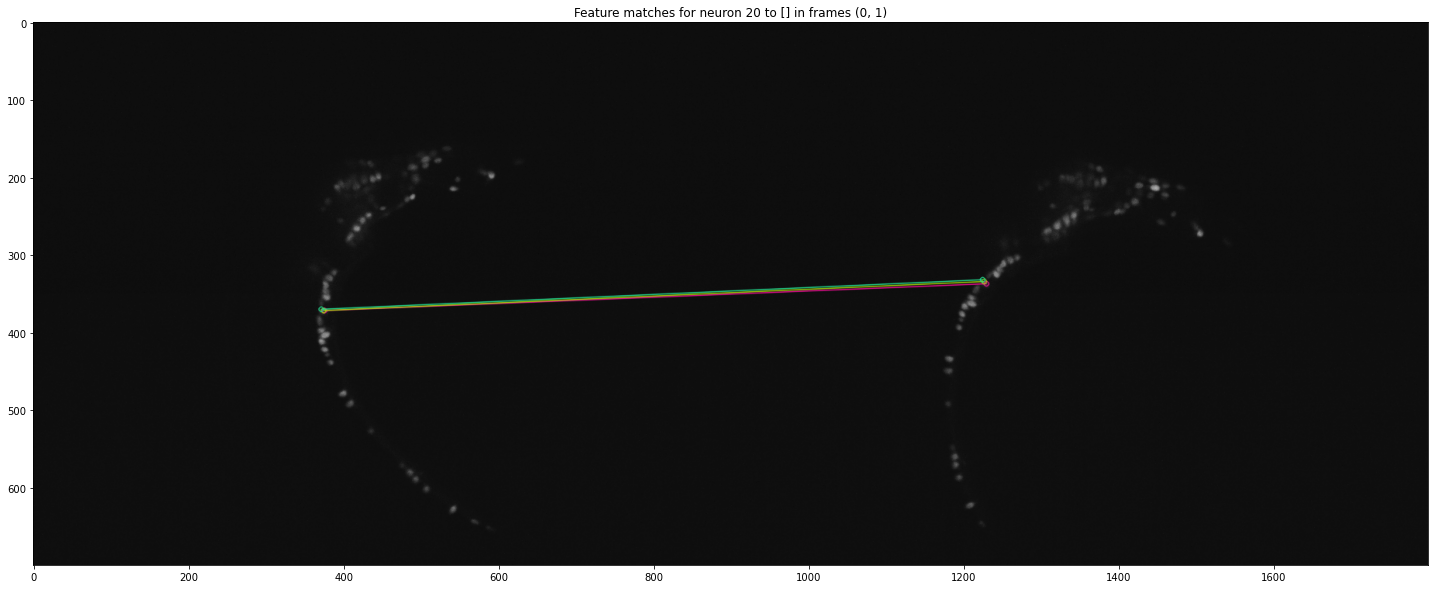

In [55]:
plot_match_example(ref_frames, 
                       neuron_matches=pairwise_matches, 
                       feature_matches=feature_matches,
                       which_frame_pair=(0,1), 
                       neuron0=20, 
                       which_slice=12)

In [ ]:
# Print locations of neuron and the found keypoints
i = 1
frame = ref_frames[0]

this_neuron = frame.neuron_locs[i]
print(f"Neuron location ({i})")
print(this_neuron)

feature_ind = frame.get_features_of_neuron(i)
print("Feature location distance")
this_kp = []
for i2, kp in enumerate(frame.keypoints):
    if i2 in feature_ind:
        this_kp.append(kp.pt)
#this_kp = frame.keypoint_locs[feature_ind]
#print(this_kp)
#all_diff = [kp-this_neuron for kp in this_kp]
#print([round(np.linalg.norm(d),1) for d in all_diff])

In [ ]:
frame.keypoints[0].pt


# Test global index generation

In [58]:
import networkx as nx
from DLC_for_WBFM.utils.feature_detection.utils_reference_frames import *


Analyzing pair:
(0, 1)
Analyzing pair:
(0, 2)
Analyzing pair:
(0, 3)
Analyzing pair:
(0, 4)
Analyzing pair:
(0, 5)
Analyzing pair:
(1, 0)
Analyzing pair:
(1, 2)
Analyzing pair:
(1, 3)
Analyzing pair:
(1, 4)
Analyzing pair:
(1, 5)
Analyzing pair:
(2, 0)
Analyzing pair:
(2, 1)
Analyzing pair:
(2, 3)
Analyzing pair:
(2, 4)
Analyzing pair:
(2, 5)
Analyzing pair:
(3, 0)
Analyzing pair:
(3, 1)
Analyzing pair:
(3, 2)
Analyzing pair:
(3, 4)
Analyzing pair:
(3, 5)
Analyzing pair:
(4, 0)
Analyzing pair:
(4, 1)
Analyzing pair:
(4, 2)
Analyzing pair:
(4, 3)
Analyzing pair:
(4, 5)
Analyzing pair:
(5, 0)
Analyzing pair:
(5, 1)
Analyzing pair:
(5, 2)
Analyzing pair:
(5, 3)
Analyzing pair:
(5, 4)


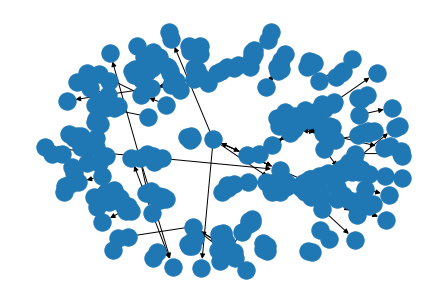

In [60]:
nx.draw(DG)

Largest connected component size:  22


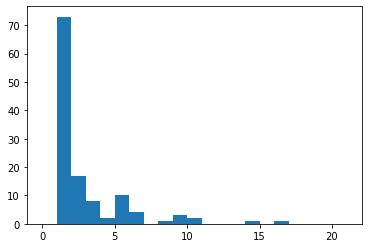

In [61]:
G = get_subgraph_with_strong_weights(DG, 0.0)
big_G, all_sz = calc_connected_components(G)
plt.hist(all_sz, bins=list(range(max(all_sz))));

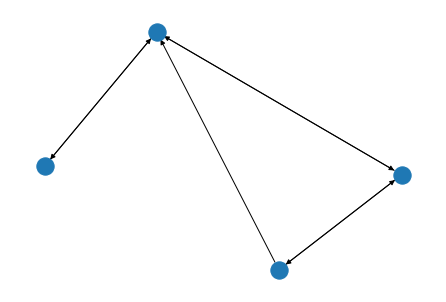

In [39]:
# All non-isolated nodes
core_G = nx.k_core(big_G, 1)
nx.draw(core_G)

In [ ]:
# Cluster based on graph embedding:
# https://stackoverflow.com/questions/62902871/how-can-i-cluster-a-graph-g-created-in-networkx

from node2vec import Node2Vec
# Generate walks
node2vec = Node2Vec(big_DG, dimensions=2, walk_length=5, num_walks=10,workers=4)
# Learn embeddings 
model = node2vec.fit(window=10, min_count=1)
#model.wv.most_similar('1')
model.wv.save_word2vec_format("embedding.emb") #save the embedding in file embedding.emb

In [ ]:
from sklearn.cluster import KMeans

X = np.loadtxt("embedding.emb", skiprows=1) # load the embedding of the nodes of the graph
#print(X)
# sort the embedding based on node index in the first column in X
X=X[X[:,0].argsort()]; 
Z=X[0:X.shape[0],1:X.shape[1]]; # remove the node index from X and save in Z

kmeans = KMeans(n_clusters=300, random_state=0).fit(Z) # apply kmeans on Z
labels=kmeans.labels_  # get the cluster labels of the nodes.
print(labels)

In [ ]:
nx.draw(big_DG, node_color=labels)

In [ ]:
# Other clustering method:
# https://networkx.org/documentation/stable/auto_examples/algorithms/plot_blockmodel.html#sphx-glr-auto-examples-algorithms-plot-blockmodel-py
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster import hierarchy
from scipy.spatial import distance


def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = np.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())


G = big_DG.to_undirected()

# Extract largest connected component into graph H
H = G.subgraph(next(nx.connected_components(G)))
# Makes life easier to have consecutively labeled integer nodes
H = nx.convert_node_labels_to_integers(H)
# Create parititions with hierarchical clustering
partitions = create_hc(H)
# Build blockmodel graph
BM = nx.quotient_graph(H, partitions, relabel=True)

# Draw original graph
pos = nx.spring_layout(H, iterations=100)
plt.subplot(211)
nx.draw(H, pos, with_labels=False, node_size=10)

# Draw block model with weighted edges and nodes sized by number of internal nodes
node_size = [BM.nodes[x]["nnodes"] * 10 for x in BM.nodes()]
edge_width = [(2 * d["weight"]) for (u, v, d) in BM.edges(data=True)]
# Set positions to mean of positions of internal nodes from original graph
posBM = {}
for n in BM:
    xy = np.array([pos[u] for u in BM.nodes[n]["graph"]])
    posBM[n] = xy.mean(axis=0)
plt.subplot(212)
nx.draw(BM, posBM, node_size=node_size, width=edge_width, with_labels=False)
plt.axis("off")
plt.show()

# Testing feature matching

In [ ]:
import cv2
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *
im = get_single_volume(btf_fname_red, 0, num_slices=33)[0,...]

In [ ]:
im.shape
kp, d = detect_features(im, 1000)

In [ ]:
kp[0].pt



In [ ]:
dat = get_single_volume(btf_fname_red, 0, num_slices=33)
dat.shape[1:]

In [ ]:
cv2.KeyPoint.convert(kp2[0,...])
#kp3 = cv2.KeyPoint_convert(kp2)

In [ ]:
a = [1, 3, 5, 7]
b = [3, 5, 6]

In [ ]:
[a.index(val) if val in a for val in b]


In [ ]:
a[0,0]